In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def distance(point1, point2):
    """
    Returns distance between two points in cartesian coordinate system.
    """
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

In [7]:
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

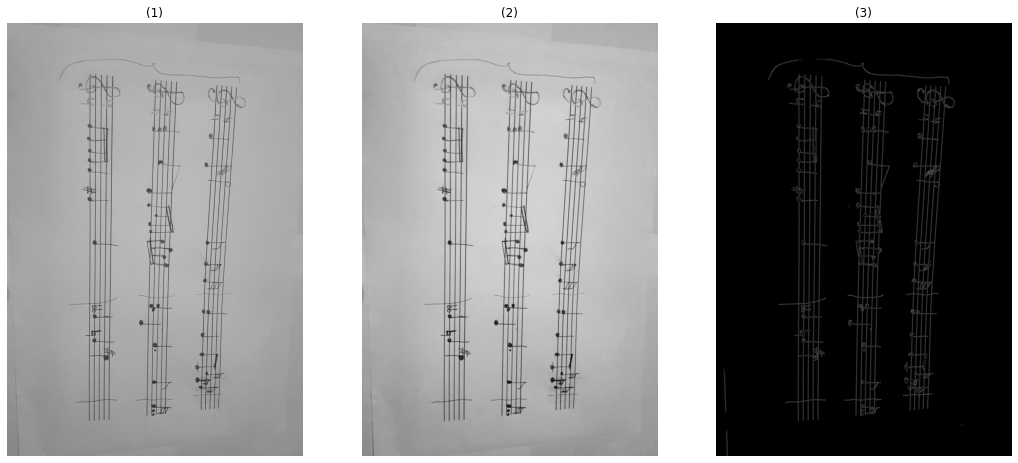

[[ 800. 1873.]
 [ 830. 1876.]
 [ 826. 2346.]
 [ 789. 2366.]]


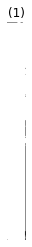

In [13]:
img = cv2.imread('testcases/test-set-camera-captured/test-cases/11.jpg')
gray = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (11, 11), 0)
edged = cv2.Canny(blurred, 0, 50)
show_images([gray, blurred, edged])

contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
for cnt in contours:
    epsilon = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * epsilon, True)
    if len(approx) == 4:
        sheet = approx
        break

if 'sheet' not in locals():
    print("Couldn't find a paper sheet in the picture!")
    sys.exit()

approx = np.asarray([x[0] for x in sheet.astype(dtype=np.float32)])

top_left = min(approx, key=lambda t: t[0] + t[1])
bottom_right = max(approx, key=lambda t: t[0] + t[1])
top_right = max(approx, key=lambda t: t[0] - t[1])
bottom_left = min(approx, key=lambda t: t[0] - t[1])

max_width = int(max(distance(bottom_right, bottom_left), distance(top_right, top_left)))
max_height = int(max(distance(top_right, bottom_right), distance(top_left, bottom_left)))

arr = np.array([
    [0, 0],
    [max_width - 1, 0],
    [max_width - 1, max_height - 1],
    [0, max_height - 1]], dtype="float32")

rectangle = np.asarray([top_left, top_right, bottom_right, bottom_left])

m = cv2.getPerspectiveTransform(rectangle, arr)
dst = cv2.warpPerspective(img, m, (max_width, max_height))

cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
cv2.imwrite("output/2with_contours.png", img)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

_, result = cv2.threshold(dst, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

show_images([result])
# cv2.imshow('Result', result)
# cv2.waitKey(0)
# cv2.imwrite("preprocessed.png", result)